<a href="https://colab.research.google.com/github/C3578/Segmentation_graph_images/blob/master/Segmentation_graph_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import random
import os
from tqdm import tqdm

In [ ]:
from fastai.vision import *

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
%matplotlib inline

##Часть 1. Подготовка данных.

### Исходные изображения обрезаются с центром по выбросу, ширина 512. Это делается для того чтобы подавать в сеть более информативные изображения, т.к. при подаче иображения без изменений много данных терялось. Сеть принимает изображения 128*128 на вход.

In [ ]:
data_root = 
list_ = os.listdir(data_root)

In [ ]:
train_root = 
list_train = os.listdir(train_root)

In [ ]:
# Находит левые и правые границы выброса.
def func_4(img):
  
  b, c = img.shape

  a = np.where((img > 222) & (img < 240), img , img*0)
  up = np.where(a[10][:] > 0)[0]
  down = np.where(a[b-10][:] > 0)[0]
  
  if len(up) % 4 == 0:
    up_1 = []
    for i in range(len(up)//4):
      up_1 += [[list(up[i*4 : i*4 + 4])[0], list(up[i*4 : i*4 + 4])[-1]]]
  else:
    up_1 = []
    if len(up)/4 < 1:
      up_1 += [[up[0], up[-1]]]
    else:
      for i in range(len(up)//4):
        up_1 += [[list(up[i*4 : i*4 + 4])[0], list(up[i*4 : i*4 + 4])[-1]]]
  

  if len(down) % 4 == 0:
    down_1 = []
    for i in range(len(down)//4):

      down_1 += [[list(down[i*4 : i*4 + 4])[0], list(down[i*4 : i*4 + 4])[-1]]]
  else:
    down_1 = []
    for i in range(len(down)//4):
      down_1 += [[list(down[i*4 : i*4 + 4])[0], list(down[i*4 : i*4 + 4])[-1]]]

  if len(up_1) != len(down_1):
    max_ = max(len(up_1), len(down_1))
    if len(up_1) != max_:
      for i in range(max_ - len(up_1)):
        up_1 += [down_1[len(up_1)  + i]]
    elif len(down_1) != max_:
      for i in range(max_ - len(down_1)):
        down_1 += [up_1[len(down_1) + i]]
  max_borders = []      
  for i in range(len(up_1)):
    max_borders += [[min(up_1[i][0], down_1[i][0]), max(up_1[i][1], down_1[i][1])]]

  return max_borders

In [ ]:
# Обрезает изображения с центром по выбросу.
def reshape_img(img):
  img_1 = cv2.imread(data_root + img)

  gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)

  a, b = gray_1.shape
  

  up_1, down_1 = func_4(gray_1)[0]
  count = 0

  for i in func_4(gray_1):
    
    left_border, right_border = i
    if left_border < 256:
      x = img_1[ : , 0 : 502, : ]

    elif right_border + 256 > b:
      x = img_1[ : , b - 502 : , : ]

    else:
      x = img_1[ : , (((right_border + left_border)//2) - 256) : (((right_border + left_border)//2) + 256), : ]

    cv2.imwrite(train_root + img.replace('.bmp', '_' + str(count) + '.bmp'), x)


In [ ]:
# Создает Маски для обрезанных изображений
def create_mask(img):
  img_1 = cv2.imread(train_root + img)

  gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)

  a, b = gray_1.shape
  z = np.zeros(gray_1.shape)

  up_1, down_1 = func_4(gray_1)[0]

  for i in func_4(gray_1):
    
    left_border, right_border = i
    if left_border < 14:
      z[ : , 0 : right_border + 9]=255

    elif right_border + 9 > b:
      z[ : , left_border - 14 : ]=255

    else:
      z[ : , left_border - 14 : right_border + 9 ]=255

  cv2.imwrite(train_root + img.replace('.bmp', '_mask.bmp'), z)

In [ ]:
# Обрежим все изображения из нашего набора данных.
for i in list_:
  reshape_img(i)

In [ ]:
# Сделаем маски для полученных изображений.
for i in list_train:
  create_mask(i)

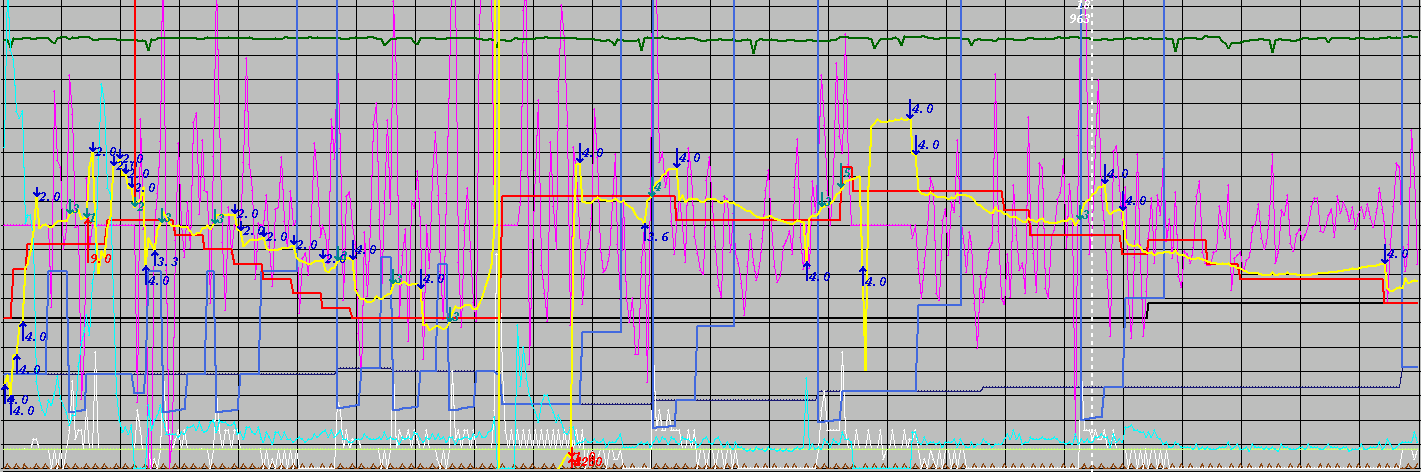

In [ ]:
# Исходное изображение
img_1 = open_image(data_root + '39.bmp')
img_1

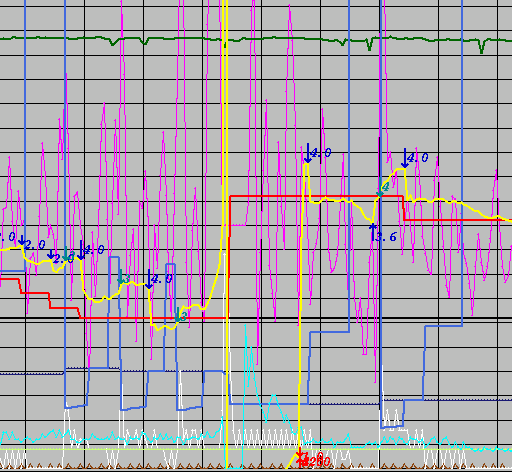

In [ ]:
# Обрезанное изображение
img_1 = open_image(train_root + '39_0.bmp')
img_1

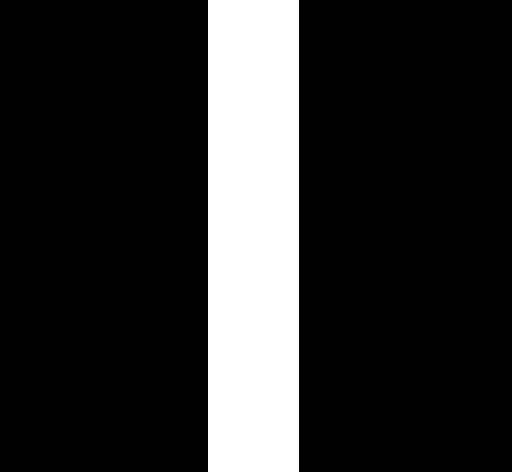

In [ ]:
# Маска для обрезанного изображения
img_1 = open_image(train_root + '39_0_mask.bmp')
img_1

# Часть 2. Сеть и обучение.

In [ ]:
import torch
import random
from fastai.vision import *
import pandas as pd
import glob

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [ ]:
path = '..'
path_images = Path('..')
path_lbl = path_images
fn_list = glob.glob('..*[!_mask].bmp') #создает список с именами img(x)
lbl_names = glob.glob('..*_mask.bmp') #создает список с именами mask(y)

In [ ]:
lbl_names[:3]

In [ ]:
fn_list[:3]

In [ ]:
def get_y_fn(x):  # выдает y(имя маски) по x
    x = Path(x)
    return path_lbl/f'{x.stem}_mask{x.suffix}'

In [ ]:
filter_func = lambda x: str(x) in fn_list

In [ ]:
from fastai.utils.mem import *

In [ ]:
size = 128
bs=4

In [ ]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)  
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom 

In [ ]:
codes = ['0','1']
src = (SegItemListCustom.from_folder(path_images)  # path_images = Path("../input/train")
       .filter_by_func(filter_func) # Сохраняет только те элементы, для которых func возвращает True.filter_func = lambda x: str(x) in fnames х 
       .split_by_rand_pct()  # Разделите элементы случайным образом, поместив valid_pct в набор проверки
       .label_from_func(get_y_fn,classes=codes))

In [ ]:
data = (src.transform(get_transforms(flip_vert=True, max_rotate=25.0), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
data.path = Path('.')

In [ ]:
def dice_func(input, target):
    smooth = 0
    input = input[:,1,:,:]
    iflat = input.flatten().float()
    tflat = target.flatten().float()
    intersection = (iflat * tflat).sum()
    return ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

def dice(input:Tensor, targs:Tensor, iou:bool=False)->Rank0Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)

In [ ]:
fn_list[0]

'../content/gdrive/My Drive/Colab Notebooks/200217_RUSAL_test/train_2/10_0.bmp'

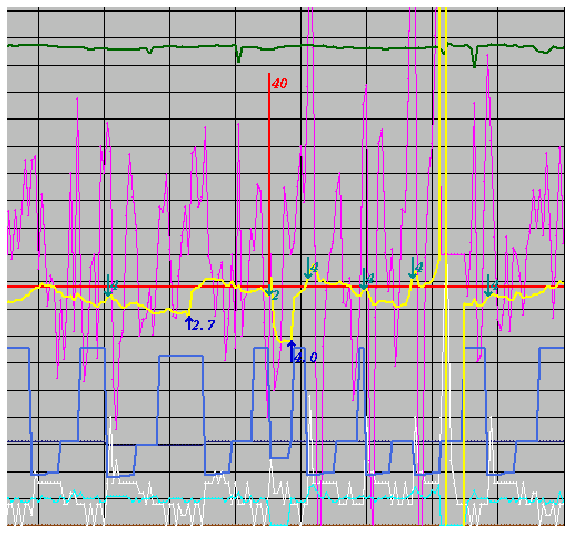

In [ ]:
img_f = fn_list[0]
img = open_image(img_f)
img.show(figsize=(10,10))

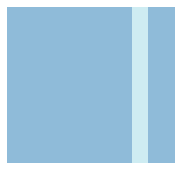

In [ ]:
mask = open_mask(get_y_fn(img_f),div=True)
mask.show()

In [ ]:
learn = unet_learner(data, models.resnet18, metrics=[dice], wd=1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5,max_lr = 1e-4)

epoch,train_loss,valid_loss,dice,time
0,0.415347,0.379696,0.100353,00:45
1,0.384225,0.264640,0.024986,00:45
2,0.357774,0.242317,0.118436,00:45
3,0.330911,0.217531,0.413093,00:45
4,0.310783,0.213691,0.463188,00:45


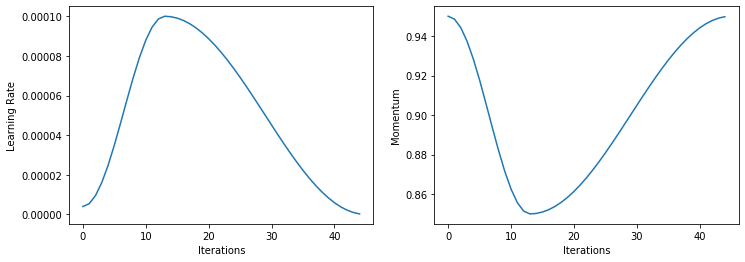

In [ ]:
learn.recorder.plot_lr(show_moms=True)

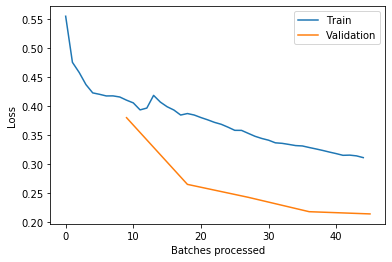

In [ ]:
learn.recorder.plot_losses()

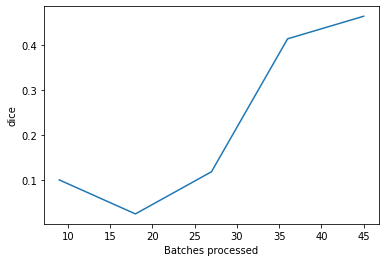

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.fit_one_cycle(20,max_lr = slice(1e-6,1e-4))

epoch,train_loss,valid_loss,dice,time
0,0.258396,0.204884,0.464132,00:45
1,0.255962,0.199006,0.419410,00:45
2,0.252012,0.179452,0.553177,00:45
3,0.247068,0.173368,0.513348,00:45
4,0.241412,0.165345,0.700088,00:45
5,0.231798,0.174482,0.725976,00:46
6,0.225948,0.157327,0.527787,00:45
7,0.221878,0.151122,0.583174,00:45
8,0.217170,0.134462,0.681810,00:45
9,0.208157,0.124837,0.750284,00:45


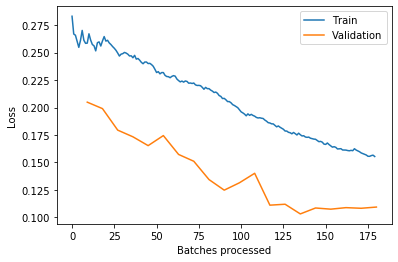

In [ ]:
learn.recorder.plot_losses()

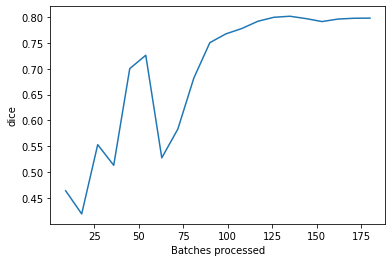

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
for i in fn_list:
  pred = learn.predict(open_image(i))
  mask = pred[0]
  img = open_image(i).resize((1, 128, 128))
  mask_2 = open_mask(i.replace('.bmp', '_mask.bmp'), div=True).resize((1, 128, 128))
  _,axs = plt.subplots(1,5, figsize=(16,8))
  img.show(ax=axs[0], title='no mask')
  img.show(ax=axs[1], y=mask_2, title='true_masked')
  img.show(ax=axs[2], y=mask, title='pred_masked')
  mask_2.show(ax=axs[3], title='true_mask only', alpha=1.)
  mask.show(ax=axs[4], title='pred_mask only', alpha=1.)
